In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
import numpy as np
from collections import defaultdict

In [2]:
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    precision_score, 
    recall_score,
    accuracy_score,
    precision_recall_fscore_support
)

In [3]:
modality_colors = {
    'MIBI': '#ff7f00',
    'CODEX': '#377eb8',
    'IMC': '#4daf4a',
    'MACSima': '#984ea3',
    'IBEX': '#ffff33',
    'CyCIF': '#a65628',
    'InSituPlex': '#f781bf',
    'CellDIVE': '#999999',
    'Vectra': '#e41a1c',
}

with open('../data/combined_cell_type_mapping.yaml') as f:
    class_mapping_to_combined = yaml.safe_load(f)

with open('../data/celltype_colors.yaml') as f:
    ct_colors = yaml.safe_load(f)

## Confusion Matrix and Stratified Analysis

In [4]:
df_pred = pd.read_csv('../data/predictions.csv')

In [5]:
df_pred['groundtruth_combined'] = df_pred['groundtruth'].map(class_mapping_to_combined)
df_pred['prediction_combined'] = df_pred['prediction'].map(class_mapping_to_combined)

In [6]:
# calculate f1 score for each celltype
celltype_f1_scores = defaultdict(list)
for celltype_name, subdf in df_pred.groupby("groundtruth"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf) < 100: # drop the data points with less than 100 examples
            continue
        ds_subdf = ds_subdf.dropna()
        f1 = f1_score(
            ds_subdf['groundtruth'],
            ds_subdf['prediction'], 
            average="weighted",
            zero_division=np.nan,
            )

        celltype_f1_scores[celltype_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-pack

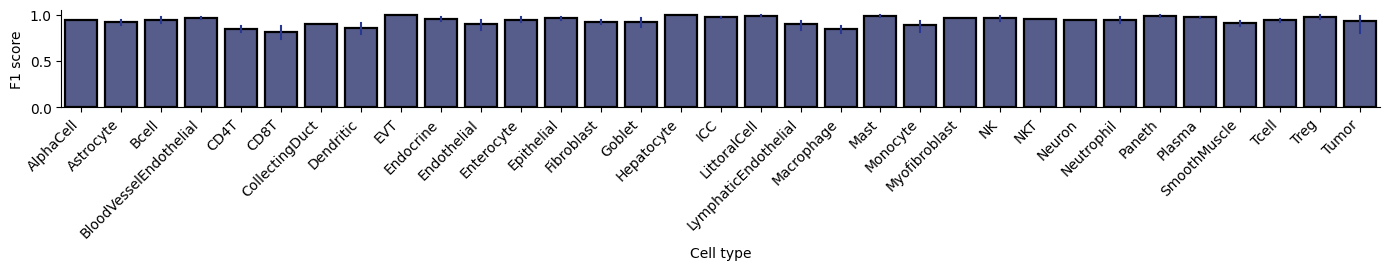

In [7]:
fig, ax = plt.subplots(figsize=(14, 2.8))
df_celltype_f1 = pd.DataFrame.from_dict(celltype_f1_scores, orient='index').transpose()
sns.barplot(data=df_celltype_f1, ax=ax, color='#4d5794', errcolor='#283890', edgecolor='black', linewidth=1.6, errwidth=1.5)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [8]:
# calculate f1 score for each combined celltype
celltype_f1_scores_combined = defaultdict(list)
for celltype_name, subdf in df_pred.groupby("groundtruth_combined"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf) < 100: # drop the data points with less than 100 examples
            continue
        ds_subdf = ds_subdf.dropna()
        f1 = f1_score(
            ds_subdf['groundtruth_combined'],
            ds_subdf['prediction_combined'], 
            average="weighted",
            zero_division=np.nan,
            )

        celltype_f1_scores_combined[celltype_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/tmp/ipykernel_582404/3788781970.py:9: UserWar

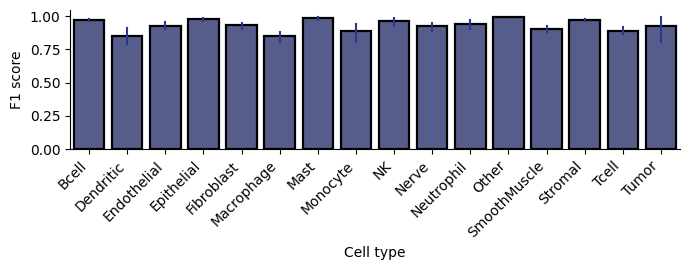

In [9]:
fig, ax = plt.subplots(figsize=(7, 2.8))
df_celltype_f1_combined = pd.DataFrame.from_dict(celltype_f1_scores_combined, orient='index').transpose()
sns.barplot(data=df_celltype_f1_combined, ax=ax, color='#4d5794', errcolor='#283890', edgecolor='black', linewidth=1.6, errwidth=1.5)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [10]:
# calculate f1 score for each modality
modality_f1_scores = defaultdict(list)
for modality_name, subdf in df_pred.groupby("modality_name"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf) < 100: # drop the data points with less than 100 examples
            continue
        f1 = f1_score(
            ds_subdf['groundtruth'],
            ds_subdf['prediction'], 
            average="weighted",
            zero_division=np.nan,
            )
        modality_f1_scores[modality_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/tmp/ipykernel_582404/4066321463.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(0.0, 1.08)

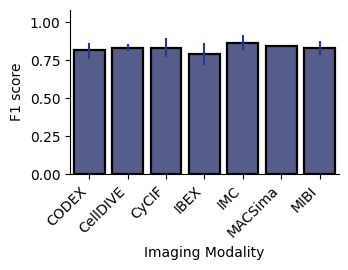

In [11]:
fig, ax = plt.subplots(figsize=(3.5, 2.8))
df_domain_f1 = pd.DataFrame.from_dict(modality_f1_scores, orient='index').transpose()
sns.barplot(data=df_domain_f1, ax=ax, color='#4d5794', errcolor='#283890', edgecolor='black', linewidth=1.6, errwidth=1.5)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Imaging Modality')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.ylim([0, 1.08])


In [12]:
# calculate f1 score for each tissue
tissue_f1_scores = defaultdict(list)
for tissue_name, subdf in df_pred.groupby("tissue_name"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf) < 100: # drop the data points with less than 100 examples
            continue
        f1 = f1_score(
            ds_subdf['groundtruth'],
            ds_subdf['prediction'], 
            average="weighted",
            zero_division=np.nan
            )
        tissue_f1_scores[tissue_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-pack

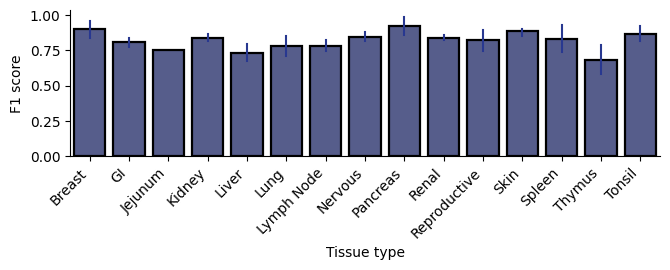

In [13]:
fig, ax = plt.subplots(figsize=(6.8, 2.8))
df_tissue_f1 = pd.DataFrame.from_dict(tissue_f1_scores, orient='index').transpose()
df_tissue_f1 = df_tissue_f1.rename({'Lymph_Node': 'Lymph Node'}, axis=1)
sns.barplot(data=df_tissue_f1, ax=ax, color='#4d5794', errcolor='#283890', edgecolor='black', linewidth=1.6, errwidth=1.5)
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Tissue type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [14]:
def plot_conf(cm):
    fig = plt.figure(figsize=(len(cm)/2, len(cm)/2))
    
    # annotate only diagonal entries
    annot = np.diag(np.diag(cm.to_numpy(), 0), 0)
    annot = np.round(annot, 1)
    annot = annot.astype("str")
    annot[annot == "0.0"] = ""

    ax = fig.add_axes([0.22, 0.2, 0.7, 0.7])

    axes = sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", ax=ax, cbar=False)
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(alpha=0.8)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

In [15]:
class_names = df_pred['groundtruth_combined'].unique()
cm = confusion_matrix(df_pred['groundtruth_combined'], df_pred['prediction_combined'], labels=class_names)
cm = pd.DataFrame(cm, columns=class_names, index=class_names)
cm = cm.div(cm.sum(axis=1), axis=0)

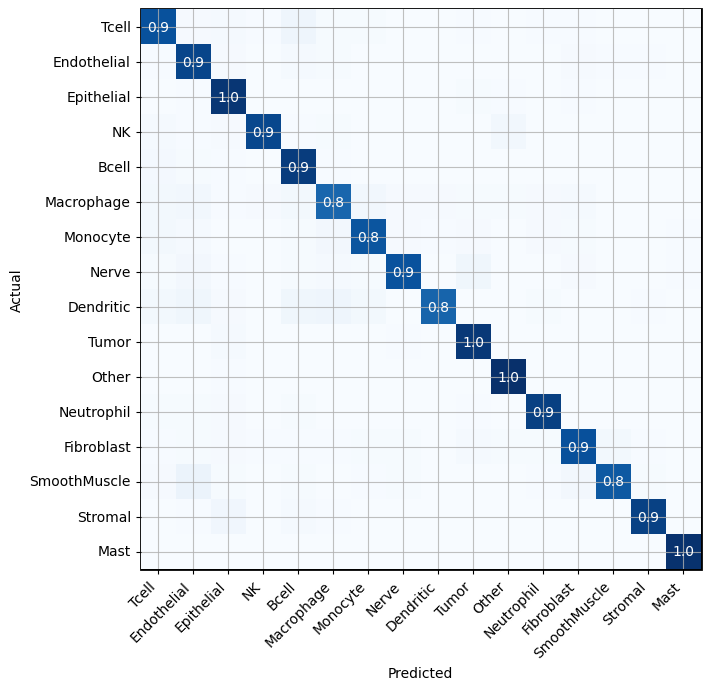

In [16]:
plot_conf(cm)

## Zero-Shot Analysis

In [17]:
combined_celltype_names = [item for item in set(list(class_mapping_to_combined.values())) if not pd.isnull(item)]

In [18]:
def cal_f1_by_expr(df, class_names, gt_name, pred_name):
    f1_list = []
    for expr_name, subdf in df.groupby('expr_name'):
        
        precision, recall, f1, support = precision_recall_fscore_support(subdf[gt_name], subdf[pred_name], average=None, labels=class_names, zero_division=np.nan)
        if np.any(support <= 500): # drop the data points with less than 500 examples
            f1[support <= 500] = np.nan

        f1[support==0] = np.nan
        f1_list.append(f1)

    df_f1_score = pd.DataFrame(f1_list, columns=class_names)
    return df_f1_score

In [19]:
df_ours = pd.read_csv('../data/zero_shot_ours.csv')

df_ours['groundtruth_combined'] = df_ours['groundtruth'].map(class_mapping_to_combined)
df_ours['prediction_combined'] = df_ours['prediction'].map(class_mapping_to_combined)

In [20]:
df_static = pd.read_csv('../data/zero_shot_ours_static.csv')

df_static['groundtruth_combined'] = df_static['groundtruth'].map(class_mapping_to_combined)
df_static['prediction_combined'] = df_static['prediction'].map(class_mapping_to_combined)

In [21]:
df_xgboost = pd.read_csv('../data/zero_shot_xgboost.csv')

df_xgboost['groundtruth_combined'] = df_xgboost['groundtruth'].map(class_mapping_to_combined)
df_xgboost['prediction_combined'] = df_xgboost['prediction'].map(class_mapping_to_combined)

In [22]:
df_maps = pd.read_csv('../data/zero_shot_maps.csv')

df_maps['groundtruth_combined'] = df_maps['groundtruth'].map(class_mapping_to_combined)
df_maps['prediction_combined'] = df_maps['prediction'].map(class_mapping_to_combined)

In [23]:
f1_ours_by_expr = cal_f1_by_expr(df_ours, combined_celltype_names, 'groundtruth_combined', 'prediction_combined')
f1_static_by_expr = cal_f1_by_expr(df_static, combined_celltype_names, 'groundtruth_combined', 'prediction_combined')
f1_xgboost_by_expr = cal_f1_by_expr(df_xgboost, combined_celltype_names, 'groundtruth_combined', 'prediction_combined')
f1_maps_by_expr = cal_f1_by_expr(df_maps, combined_celltype_names, 'groundtruth_combined', 'prediction_combined')


In [24]:
rare_category = (~f1_ours_by_expr.isnull()).sum() <= 3

f1_xgboost_by_expr = f1_xgboost_by_expr.loc[:, ~rare_category]
f1_maps_by_expr = f1_maps_by_expr.loc[:, ~rare_category]
f1_ours_by_expr = f1_ours_by_expr.loc[:, ~rare_category]
f1_static_by_expr = f1_static_by_expr.loc[:, ~rare_category]

In [25]:
# Merge all F1 scores together
f1_xgboost_by_expr['Method'] = 'XGBoost'
f1_ours_by_expr['Method'] = 'Ours'
f1_maps_by_expr['Method'] = 'MAPS'

df_f1_score_by_expr = pd.concat([f1_xgboost_by_expr, f1_maps_by_expr, f1_ours_by_expr])

df_f1_score_by_expr_melted = df_f1_score_by_expr.melt(id_vars='Method', var_name='Class', value_name='F1_Score')
df_f1_score_by_expr_melted = df_f1_score_by_expr_melted.dropna()

df_f1_score_by_expr_melted['Method'] = pd.Categorical(df_f1_score_by_expr_melted['Method'], ordered=True, 
                              categories= ['XGBoost', 'MAPS', 'Ours'])

df_f1_score_by_expr_melted = df_f1_score_by_expr_melted.sort_values(['Method','Class'])

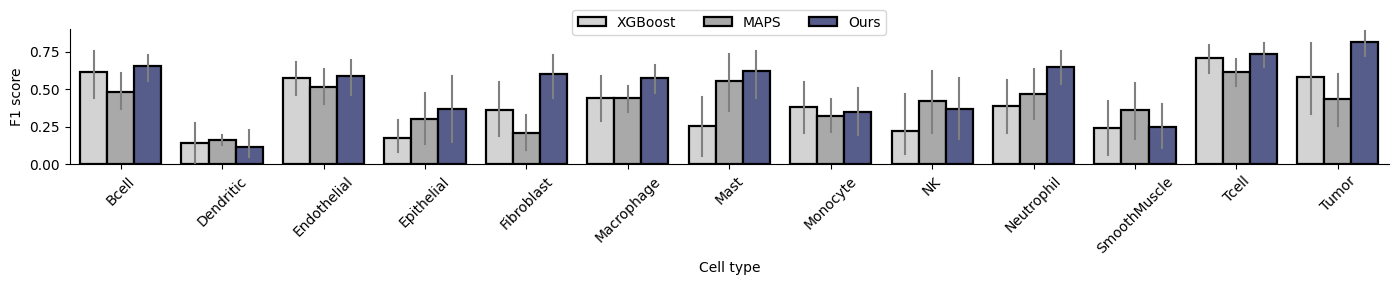

In [26]:
my_palette = ['lightgrey', 'darkgrey', '#4d5794']
fig, ax = plt.subplots(figsize=(14, 3))
sns.barplot(x='Class', y='F1_Score', hue='Method', data=df_f1_score_by_expr_melted, palette=my_palette, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.xticks(rotation=45)
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncols=3)
plt.ylim([0, 0.9])
plt.tight_layout()


In [27]:
# Merge all F1 scores together
f1_static_by_expr['Method'] = 'Static'
f1_ours_by_expr['Method'] = 'Dynamic'

df_f1_score_by_expr = pd.concat([f1_static_by_expr, f1_ours_by_expr])

df_f1_score_by_expr_melted = df_f1_score_by_expr.melt(id_vars='Method', var_name='Class', value_name='F1_Score')
df_f1_score_by_expr_melted = df_f1_score_by_expr_melted.dropna()

df_f1_score_by_expr_melted['Method'] = pd.Categorical(df_f1_score_by_expr_melted['Method'], ordered=True, 
                              categories= ['Static', 'Dynamic'])

df_f1_score_by_expr_melted = df_f1_score_by_expr_melted.sort_values(['Method','Class'])

In [28]:
df_aggregated_score = pd.DataFrame({
        'XGBoost': f1_xgboost_by_expr.mean(axis=1, skipna=True),
        'MAPS': f1_maps_by_expr.mean(axis=1, skipna=True),
        'Ours': f1_ours_by_expr.mean(axis=1, skipna=True),
    })

df_aggregated_score_melted = df_aggregated_score.melt(value_vars=df_aggregated_score.columns, var_name='Series', value_name='Value')
df_aggregated_score_melted['Method'] = 'Aggregated'
df_aggregated_score.mean(), df_aggregated_score.std()

/tmp/ipykernel_582404/1084514547.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'XGBoost': f1_xgboost_by_expr.mean(axis=1, skipna=True),
/tmp/ipykernel_582404/1084514547.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'MAPS': f1_maps_by_expr.mean(axis=1, skipna=True),
/tmp/ipykernel_582404/1084514547.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Ours': f1_ours_by_expr.mean(axis=1, skipna=True),


(XGBoost    0.457875
 MAPS       0.427419
 Ours       0.550732
 dtype: float64,
 XGBoost    0.171797
 MAPS       0.117436
 Ours       0.084054
 dtype: float64)

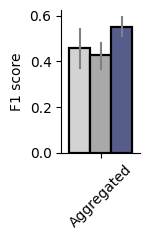

In [29]:
fig, ax = plt.subplots(figsize=(1.6, 2.5))
sns.barplot(x='Method', y='Value', hue='Series', data=df_aggregated_score_melted, palette=my_palette, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.legend([],[], frameon=False) 
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

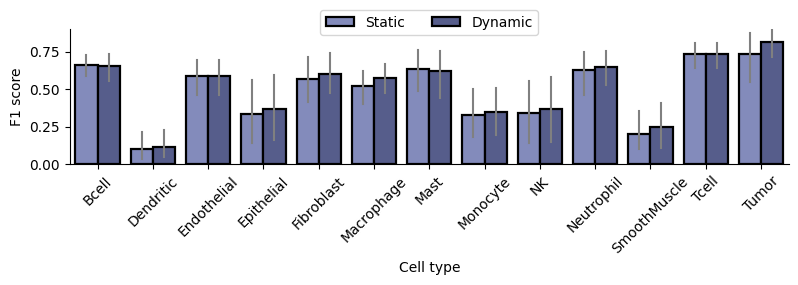

In [30]:
my_palette_1 = ['#7a84c4', '#4d5794']
fig, ax = plt.subplots(figsize=(8, 3))
sns.barplot(x='Class', y='F1_Score', hue='Method', data=df_f1_score_by_expr_melted, palette=my_palette_1, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.xticks(rotation=45)
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.05), ncols=3)
plt.ylim([0, 0.9])
plt.tight_layout()

In [31]:
df_aggregated_score = pd.DataFrame({
        'Static': f1_static_by_expr.mean(axis=1, skipna=True),
        'Dynamic': f1_ours_by_expr.mean(axis=1, skipna=True),
    })

df_aggregated_score_melted = df_aggregated_score.melt(value_vars=df_aggregated_score.columns, var_name='Series', value_name='Value')
df_aggregated_score_melted['Method'] = 'Aggregated'
df_aggregated_score.mean(), df_aggregated_score.std()

/tmp/ipykernel_582404/1545278023.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Static': f1_static_by_expr.mean(axis=1, skipna=True),
/tmp/ipykernel_582404/1545278023.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'Dynamic': f1_ours_by_expr.mean(axis=1, skipna=True),


(Static     0.527821
 Dynamic    0.550732
 dtype: float64,
 Static     0.099551
 Dynamic    0.084054
 dtype: float64)

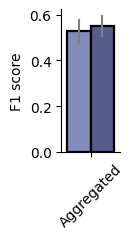

In [32]:
fig, ax = plt.subplots(figsize=(1.4, 2.5))
sns.barplot(x='Method', y='Value', hue='Series', data=df_aggregated_score_melted, palette=my_palette_1, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.legend([],[], frameon=False) 
plt.xticks(rotation=45)
plt.xlabel(None)
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

## Embedding Visualization

In [33]:
data = np.load('../data/embeddings.npz')
cls_token_embedding = data['cls_token_embedding']
ct_str = data['ct_str']
modality_str = data['modality_str']

ct_str_combined = [class_mapping_to_combined[ct] for ct in ct_str]

In [34]:
X = cls_token_embedding
y = ct_str_combined

# Perform NCA
nca = NeighborhoodComponentsAnalysis(random_state=0, n_components=10)
X_new = nca.fit_transform(X, y)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
embeddings_2d = tsne.fit_transform(X_new)

# Create a DataFrame for plotting
df_tsne = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'domain_str': modality_str,
    'ct_str': ct_str_combined,
})

# Shuffle the DataFrame
df_tsne_shuffled = df_tsne.sample(frac=1)

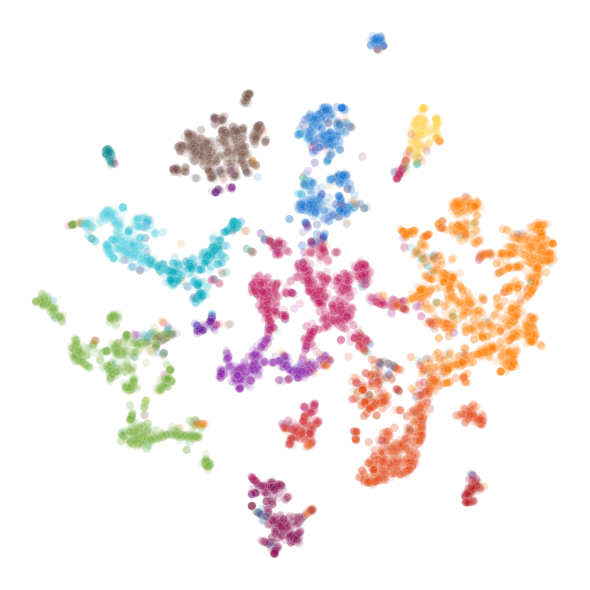

In [35]:
fig, ax1 = plt.subplots(figsize=(6,6))

sns.scatterplot(x='x', y='y', hue='ct_str', data=df_tsne_shuffled, palette=ct_colors, alpha=0.15, 
                ax=ax1, legend=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.tight_layout()

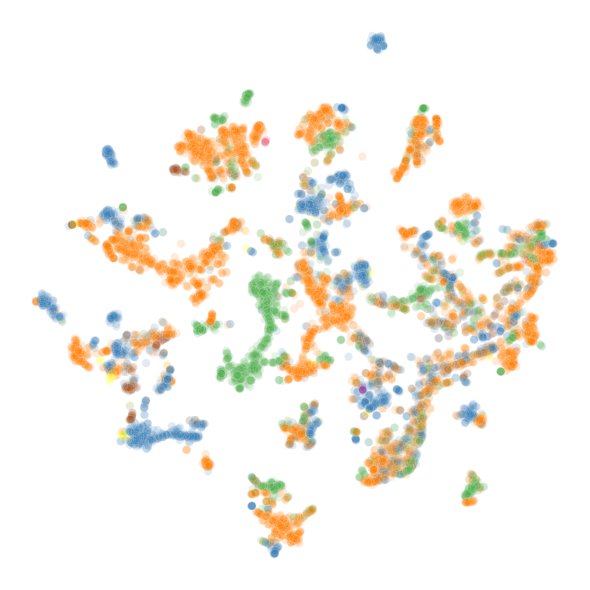

In [36]:
fig, ax2 = plt.subplots(figsize=(6,6))

sns.scatterplot(x='x', y='y', hue='domain_str', data=df_tsne_shuffled, palette=modality_colors, alpha=0.15, 
                ax=ax2, style_order=['MIBI', 'CODEX', 'IMC', 'MACSima', 'IBEX', 'CellDIVE'], legend=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.tight_layout()


In [37]:
import matplotlib.patches as mpatches

def plot_my_colors(my_colors, num_columns):

    # Create a figure and an axes object
    fig, ax = plt.subplots(figsize=(num_columns * 2, (len(my_colors) // num_columns + 1) * 0.5))
    ax.axis('off')  # Hide the axes

    patches = []
    for my, color in my_colors.items():
        patch = mpatches.Patch(color=color, label=my)
        patches.append(patch)

    # Calculate number of rows needed
    num_rows = (len(patches) + num_columns - 1) // num_columns

    legend = ax.legend(handles=patches, loc='center', ncol=num_columns,
                       frameon=False, fontsize=12, handlelength=1.5, handletextpad=0.5,
                       columnspacing=2)

    plt.tight_layout()

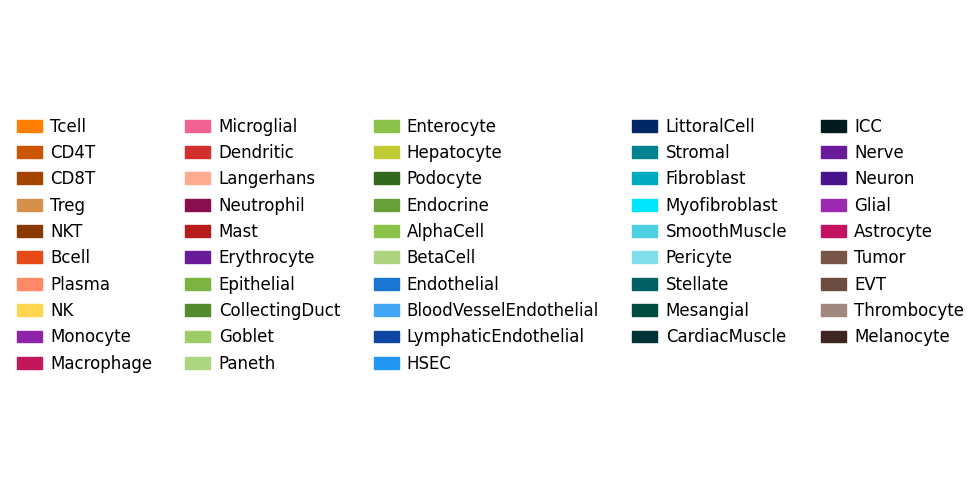

In [38]:
plot_my_colors(ct_colors, 5)

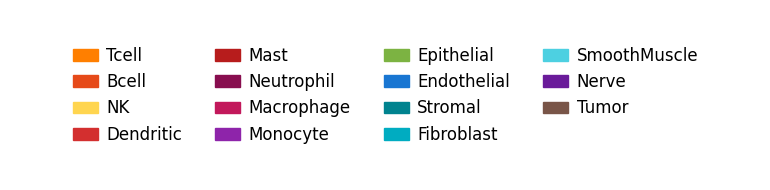

In [39]:
ct_combined_colors = {k: ct_colors[k] for k in class_mapping_to_combined.values() if k != 'Other'}
plot_my_colors(ct_combined_colors, 4)

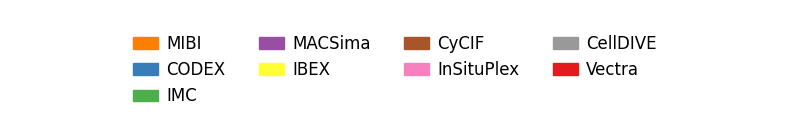

In [40]:
plot_my_colors(modality_colors, 4)

## Marker Positivity

In [41]:
def calculate_metric(df, gt_name, method_name):
    
    df["tp"] = np.logical_and(df[gt_name] == 1, df[method_name] > 0.5).astype(int)
    df["fp"] = np.logical_and(df[gt_name] == 0, df[method_name] > 0.5).astype(int)
    df["fn"] = np.logical_and(df[gt_name] == 1, df[method_name] <= 0.5).astype(int)
    df["tn"] = np.logical_and(df[gt_name] == 0, df[method_name] <= 0.5).astype(int)

    precision = df.groupby("dataset").sum(["tp", "fp", "fn", "tn"]).apply(lambda x: x["tp"]/(x["tp"] + x["fp"]), axis=1)

    recall = df.groupby("dataset").sum(["tp", "fp", "fn", "tn"]).apply(lambda x: x["tp"]/(x["tp"] + x["fn"]), axis=1)

    f1 = 2 * precision * recall / (precision + recall)
    
    accuracy = df.groupby("dataset").sum(["tp", "fp", "fn", "tn"]).apply(lambda x: (x["tp"] + x["tn"]) / (x["tp"] + x["tn"] + x["fp"] + x["fn"]) , axis=1)

    metric_df = pd.DataFrame({"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1}).reset_index(drop=True)
    return metric_df

### On Our Data

In [42]:
df = pd.read_csv('../data/marker_positivity_our_data.csv')

metric_nimbus = calculate_metric(df, 'gt', 'nimbus')
metric_ours = calculate_metric(df, 'gt', 'ours')

In [43]:
# Merge all F1 scores together
metric_ours['Method'] = 'Ours'
metric_nimbus['Method'] = 'Nimbus'

df_mp = pd.concat([metric_nimbus, metric_ours])

df_mp_melted = df_mp.melt(id_vars='Method', var_name='Metric', value_name='Value')
df_mp_melted = df_mp_melted.dropna()

df_mp_melted['Method'] = pd.Categorical(df_mp_melted['Method'], ordered=True, 
                              categories= ['Nimbus', 'Ours'])

df_mp_melted['Metric'] = pd.Categorical(df_mp_melted['Metric'], ordered=True, 
                              categories= ['F1', 'Precision', 'Recall', 'Accuracy'])

df_mp_melted = df_mp_melted.sort_values(['Method','Metric'])

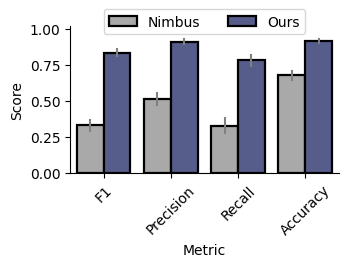

In [44]:
my_palette_2 = ['darkgrey', '#4d5794']
fig, ax = plt.subplots(figsize=(3.5, 2.8))
sns.barplot(x='Metric', y='Value', hue='Method', data=df_mp_melted, palette=my_palette_2, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.xticks(rotation=45)
plt.xlabel('Metric')
plt.ylabel('Score')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.03), ncols=3)
plt.ylim([0, 1.02])
plt.tight_layout()

### On Nimbus Data

In [50]:
df = pd.read_csv('../data/marker_positivity_nimbus_data.csv')

# Drop ambiguous labels
df = df[(df['gt_gold'] < 2) & (df['gt_silver'] < 2)]

metric_nimbus_gold = calculate_metric(df, 'gt_gold', 'nimbus')
metric_ours_gold = calculate_metric(df, 'gt_gold', 'ours')

In [51]:
# Merge all F1 scores together
metric_ours_gold['Method'] = 'Ours'
metric_nimbus_gold['Method'] = 'Nimbus'

df_mp = pd.concat([metric_nimbus_gold, metric_ours_gold])

df_mp_melted = df_mp.melt(id_vars='Method', var_name='Metric', value_name='Value')
df_mp_melted = df_mp_melted.dropna()

df_mp_melted['Method'] = pd.Categorical(df_mp_melted['Method'], ordered=True, 
                              categories= ['Nimbus', 'Ours'])

df_mp_melted['Metric'] = pd.Categorical(df_mp_melted['Metric'], ordered=True, 
                              categories= ['F1', 'Precision', 'Recall', 'Accuracy'])

df_mp_melted = df_mp_melted.sort_values(['Method','Metric'])

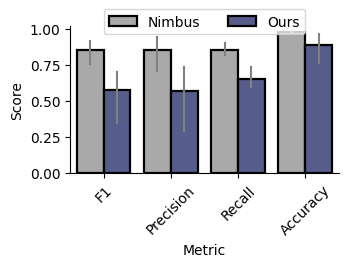

In [52]:
my_palette_2 = ['darkgrey', '#4d5794']
fig, ax = plt.subplots(figsize=(3.5, 2.8))
sns.barplot(x='Metric', y='Value', hue='Method', data=df_mp_melted, palette=my_palette_2, edgecolor='black', errcolor='0.5', linewidth=1.6, errwidth=1.5)
plt.xticks(rotation=45)
plt.xlabel('Metric')
plt.ylabel('Score')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.03), ncols=3)
plt.ylim([0, 1.02])
plt.tight_layout()